# Model Selection of National Electronic Injury Surveillance System (NEISS)
## A Project of Data Science and Machine Learning Course
### Chelsea Chen (2019)

## Background

Injury is a major cause of morbidity and mortality in the United States. Although the National Vital Statistics System provides data on injury-related deaths, a national surveillance system is needed for timely identification of emerging nonfatal injury problems and continuous monitoring of severe nonfatal injuries [1]. The Consumer Product Safety Commission (CPSC) has operated a statistically valid injury surveillance and follow-back system known as the National Electronic Injury Surveillance System (NEISS) for more than 45 years. The work assesses the feasibility of expanding the NEISS to monitor all types and causes of nonfatal injuries treated in US hospital emergency departments and reports national estimates generated by a pilot study of this system [2]. This project aims to build an optimum model for predicting and estimating the product-related injuries based on the data of 2018.

[NEISS](https://www.cpsc.gov/Research--Statistics/NEISS-Injury-Data/) dataset is based on a nationally representative probability sample of hospitals in the U.S. and its territories. 10,000 records were randomly selected from the dataset for this analysis. Patient information is collected from each NEISS hospital for every emergency department visit associated with a consumer product or a poisoning to a child younger than five years of age. The total number of product-related hospital emergency department visits nationwide can be estimated from the sample of cases reported in the NEISS.

## Process of Model Selection

In [1045]:
%matplotlib notebook
from IPython.display import display, HTML, Image
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import patsy
import random
import warnings

import time
import sklearn.linear_model as linear
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold, validation_curve, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

plt.style.use('seaborn-whitegrid')
sns.set(style = 'whitegrid')
warnings.filterwarnings('ignore')

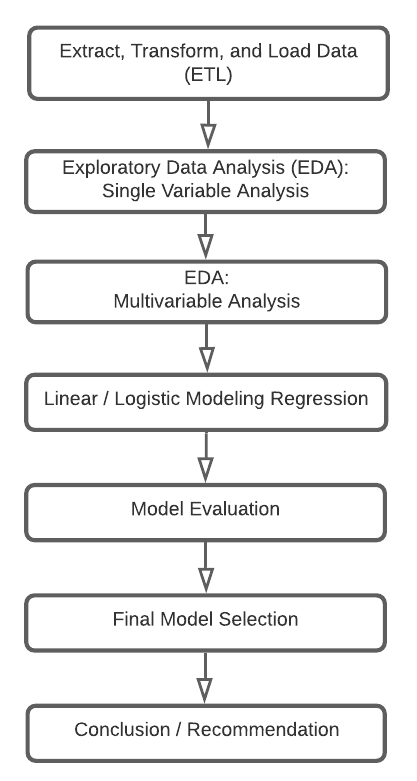

In [1046]:
Image(filename = './resources/Model_Selection_Process.png') #The figure was made using Lucidchart. https://www.lucidchart.com/pages/

We are going to follow above process to perform the model selections.

## ETL 

In [1047]:
df = pd.read_csv('neiss.csv')  #Load the data
df.head(3)

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,180106119,1/1/2018,57,2,2,NaN,79,53,NaN,1,1,0,4074,611,57 YO F CAREGIVER WAS BATHING PT WHEN PT SLID ...,NaN,S,71,70.9703
1,180106122,1/1/2018,70,1,1,NaN,76,59,NaN,1,0,0,4057,0,70 YO M VOMITTING AND PASSED OUT HITTING HEAD ...,NaN,S,71,70.9703
2,180106156,1/1/2018,75,1,1,NaN,75,59,NaN,1,1,0,1807,0,75YOM-SCALP LAC-FELL HITTING HEAD ON CONCRETE ...,NaN,S,11,70.9703


First of all, let us look at the column headers. Since the aim of this project is to build a model for predicting and estimating the product-related injuries, it intuitively seems that the features, 'Age', 'Sex', 'Race', 'Location', 'Fire_Involvement', are correlated to injury 'Disposition'. So we will focus on these 5 independent variables.

In [1048]:
columns = ['Disposition', 'Age', 'Sex', 'Race', 'Location', 'Fire_Involvement', ] #Parse out the interesting variables.
df = df[columns]
df.head()

,Disposition,Age,Sex,Race,Location,Fire_Involvement
0,1,57,2,2,1,0
1,1,70,1,1,0,0
2,1,75,1,1,1,0
3,1,34,1,1,1,0
4,1,33,1,3,1,0


In [1049]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Disposition       10000 non-null  int64
 1   Age               10000 non-null  int64
 2   Sex               10000 non-null  int64
 3   Race              10000 non-null  int64
 4   Location          10000 non-null  int64
 5   Fire_Involvement  10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB


There are 10,000 entried in the dataset. 'Disposition', 'Sex', 'Race', 'Location', and "Fire_Involvement' are given as categorical variables, 'Age' seems a numerical variable.

Next, let us make some modifications on the encoded categorical values for 'Disposition', 'Sex', 'Race', 'Location', and "Fire_Involvement'. Instead of the numeric codes, we will simply use their true labels to better understand the data.

Let us start this with the dependent/target variable 'Disposition'.

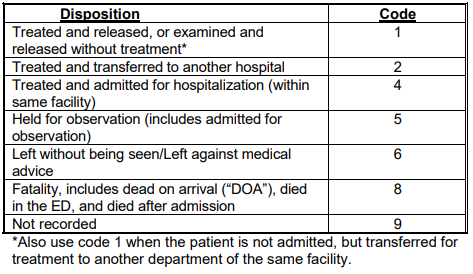

In [1050]:
Image(filename = './resources/disp_codes.png')  #This table was provided by the original dataset.

There are 7 categories in above table, let us replace the codes with their true labels.

In [1051]:
disposition_labels = {1: 'released', 2: 'transferred', 4: 'admitted', 5: 'observed', 6: 'left', 8: 'fatal', 9: 'NotRecorded'}
df['Disposition'] = df['Disposition'].replace(disposition_labels)

In [1052]:
df['Disposition'].value_counts()

released       8540
admitted       1100
left            170
transferred     112
observed         68
fatal             9
NotRecorded       1
Name: Disposition, dtype: int64

Since there is only one entry showing 'NotRecorded' for disposition, let us just elimite it. 

In [1053]:
df = df.drop(df[df.Disposition == 'NotRecorded'].index)
df = df.reset_index(drop=True)

In [1054]:
df.info();
df['Disposition'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Disposition       9999 non-null   object
 1   Age               9999 non-null   int64 
 2   Sex               9999 non-null   int64 
 3   Race              9999 non-null   int64 
 4   Location          9999 non-null   int64 
 5   Fire_Involvement  9999 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 468.8+ KB


released       8540
admitted       1100
left            170
transferred     112
observed         68
fatal             9
Name: Disposition, dtype: int64

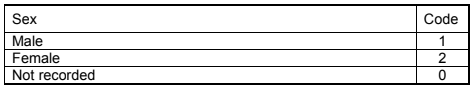

In [1055]:
Image(filename = './resources/sex.png')  #This table was provided by the original dataset.

In [1056]:
df.Sex = df.Sex.replace({0: 'Unknown', 1: 'Male', 2: 'Female'})

In [1057]:
df.Sex.value_counts()

Male      5141
Female    4858
Name: Sex, dtype: int64

The numbers of injuried male and female are close, no 'Not recorded' or 'Unknown' entity is observed from the dataset.

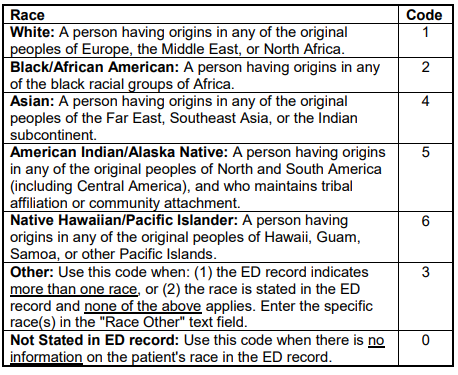

In [1058]:
Image(filename = './resources/race.png')  #This table was provided by the original dataset.

In [1059]:
df['Race'] = df['Race'].replace({0: 'Unknown', 1: 'White', 2: 'Black', 3: 'Other', 4: 'Asian', 5: 'AmericanIndian', 6: 'NativeHawaiian'})

In [1060]:
df.Race.value_counts()

Unknown           4470
White             3956
Black             1196
Other              253
Asian               98
AmericanIndian      20
NativeHawaiian       6
Name: Race, dtype: int64

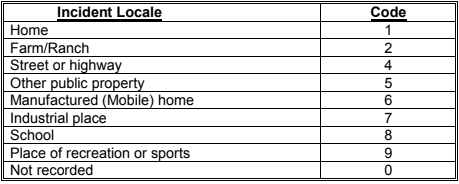

In [1061]:
Image(filename="./resources/locations.png")  #This table was provided by the original dataset.

In [1062]:
df['Location'] = df['Location'].replace({0: 'Unknown', 1: 'Home', 2: 'Farm_Ranch', 4: 'Street_Highway', 5: 'PublicProperty', 6: 'MobileHome', 7: 'IndustrialPlace', 8: 'School', 9: 'SportRelated'})

In [1063]:
df.Location.value_counts()

Home               5092
Unknown            2629
SportRelated        992
PublicProperty      739
School              426
Street_Highway      116
MobileHome            3
IndustrialPlace       1
Farm_Ranch            1
Name: Location, dtype: int64

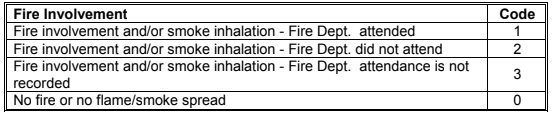

In [1064]:
Image(filename = './resources/fire.png') #This table was provided by the original dataset.

In [1065]:
df['Fire_Involvement'] = df['Fire_Involvement'].replace({0: 'NoFire', 1: 'YesFire', 2: 'YesFire', 3: 'YesFire'})

In [1066]:
df.Fire_Involvement.value_counts()

NoFire     9931
YesFire      68
Name: Fire_Involvement, dtype: int64

Next, let us look at the numerical variable 'Age'

In [1067]:
df['Age'].describe()

count    9999.000000
mean       47.797680
std        46.533891
min         2.000000
25%        15.000000
50%        37.000000
75%        66.000000
max       223.000000
Name: Age, dtype: float64

It is surprised to see that the max age is 223. This is because the ages are coded in the data as 2xx where xx is 1-23 months old for people who are under 2 years old (based on the instruction of the dataset).
So we need to transform these ages into normal format.

In [1068]:
def convertBabyAges(series):
  baby_ix = series.loc[series > 200].index
  series[baby_ix] = series[baby_ix].mod(200) / 12  #convert baby 2xx into decimal years
  return series

In [1069]:
df.Age = convertBabyAges(df.Age)

In [1070]:
df.sample(10)

,Disposition,Age,Sex,Race,Location,Fire_Involvement
9308,released,58.0,Male,White,SportRelated,NoFire
3448,released,1.5,Female,White,Home,NoFire
4883,released,43.0,Male,Black,Home,NoFire
6748,released,6.0,Male,Unknown,SportRelated,NoFire
1202,released,56.0,Male,White,Unknown,NoFire
2505,released,61.0,Female,Unknown,Street_Highway,NoFire
5086,released,5.0,Female,Unknown,School,NoFire
6124,released,46.0,Female,Unknown,Unknown,NoFire
9226,released,79.0,Female,White,Home,NoFire
8254,released,16.0,Female,Black,SportRelated,NoFire


Now the dataset seems clean and relatively easier to read.

## EDA: Single Variable Analysis

Let's begin the single variable exploratory data analysis (EDA). We will investigate any interesting distributions and surprising features of the dataset, and perform necessary transform or manipulate.

#### Age (numerical float variable)

In [1071]:
import EDA_utils as eda 

,count,mean,std,min,25%,50%,75%,max,Range,IQR,COV,Variance,Unique Values,Skewed
Age,9999.0,37.192661,27.959612,0.083333,12.0,32.0,60.0,103.0,102.916667,48.0,75.175079,781.739912,125.0,right [0.40]


<IPython.core.display.Javascript object>


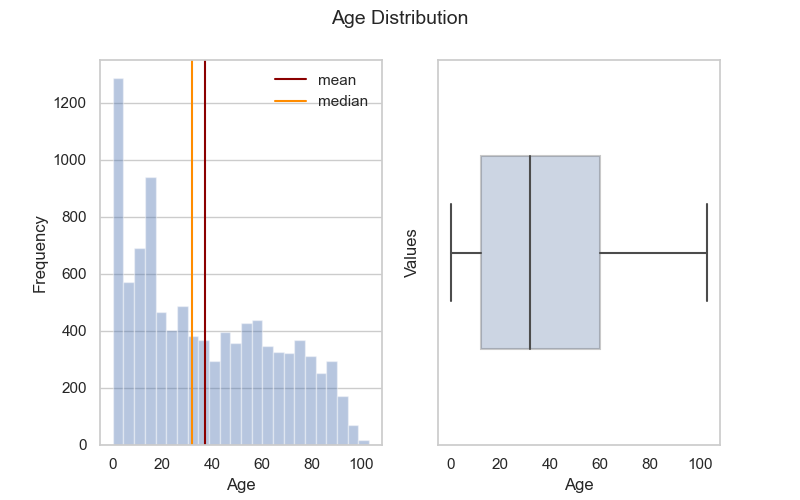

In [1072]:
eda.variable_details(df.Age);
eda.single_variable_dist(df.Age)

The age distribution of the injury data is heavily skewed right whereby younger ages dominate. This is due to the fact that many infants (<2 years old) were included in the database and were already accounted for with a conversion from months to decimal years. 

#### Sex (categorical)

In [1073]:
eda.variable_details(df.Sex);

Sex,Count,Frequency (%)
Male,5141,51.415142
Female,4858,48.584858


The table shows that the numbers of injured male and female are very close (51% vs. 49%)

#### Race (categorical)

Race,Count,Frequency (%)
Unknown,4470,44.704470
White,3956,39.563956
Black,1196,11.961196
Other,253,2.530253
Asian,98,0.980098
AmericanIndian,20,0.200020
NativeHawaiian,6,0.060006


<IPython.core.display.Javascript object>


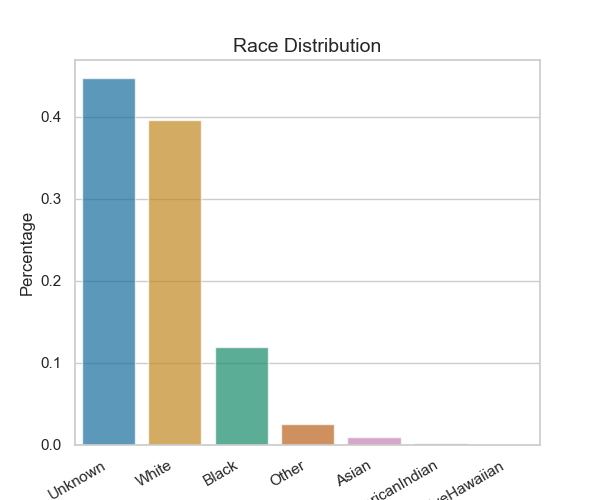

In [1074]:
eda.variable_details(df.Race);
eda.single_variable_dist(df.Race, rotation=30)

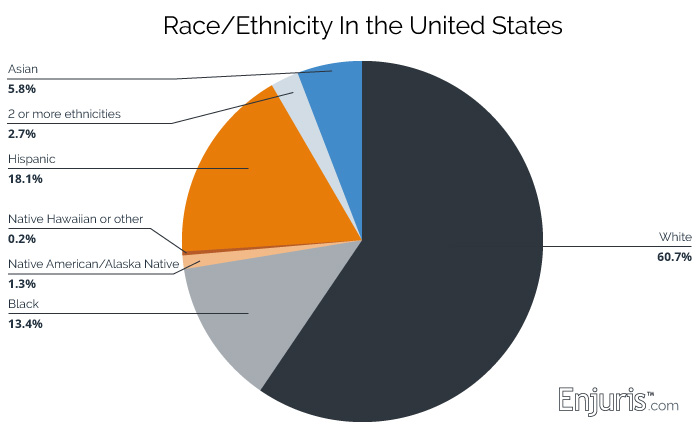

In [1075]:
Image(filename = './resources/Race_Distribution_2018.jpg') # Source: https://www.enjuris.com/students/law-school-race-2018.html

#### Location (categorical)

Location,Count,Frequency (%)
Home,5092,50.925093
Unknown,2629,26.292629
SportRelated,992,9.920992
PublicProperty,739,7.390739
School,426,4.260426
Street_Highway,116,1.160116
MobileHome,3,0.030003
IndustrialPlace,1,0.010001
Farm_Ranch,1,0.010001


<IPython.core.display.Javascript object>


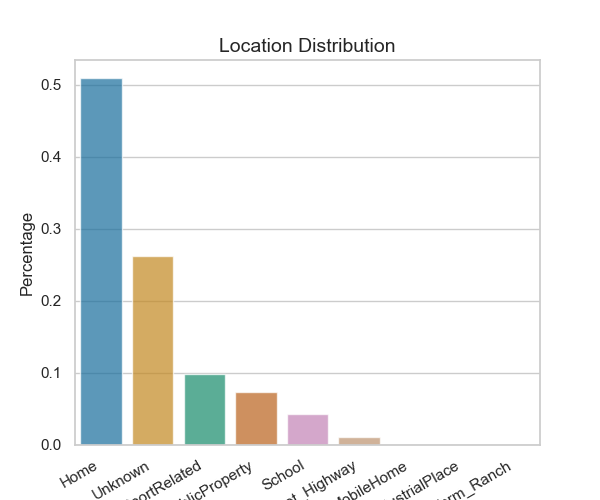

In [1076]:
eda.variable_details(df.Location)
eda.single_variable_dist(df.Location, rotation=30)

The location distribution of the injury is somehow surprised to me. Intuitively I would think that home is the safest place but the data shows that there is a great amount of people who got injured at home. This may be explaied by that people spend more time at home, and some home activies, such as cooking and yardwork, may cause injury. Besides, this data seems to being correlated with age distribution. We have known that young people domain the age distribution, and these people tend to stay at home rather than going to public/highway/farm/industrial places. So it might be necessary to investigate whether there is any correlation between location and age.

#### Fire (categorical)

Fire_Involvement,Count,Frequency (%)
NoFire,9931,99.319932
YesFire,68,0.680068


<IPython.core.display.Javascript object>


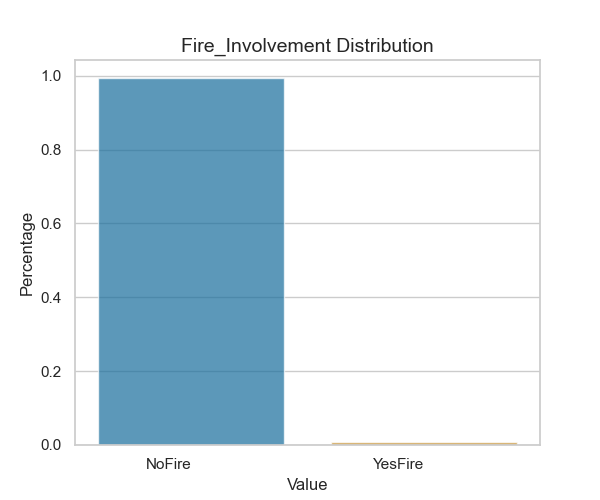

In [1077]:
eda.variable_details(df.Fire_Involvement)
eda.single_variable_dist(df.Fire_Involvement)

Only less than 1% of the injuries were correlated with fire. It is hard to believe that the variable fire has a strong influence on dispositon or other variables.

## EDA: Multivariable Analysis

Next, let us explore how each independent variable relates to the dependent variable 'Disposition'.

#### Disposition vs. Age

In [1078]:
eda.describe_by_category(df, "Disposition", "Age") #Grouped by different categorories of Disposition.

,count,mean,std,min,25%,50%,75%,max
Disposition,,,,,,,,
admitted,1100.0,64.670000,24.986192,0.083333,54.00,71.0,83.00,103.0
fatal,9.0,58.444444,19.086062,15.000000,52.00,61.0,70.00,78.0
left,170.0,32.111275,21.660295,0.166667,16.00,28.0,48.00,95.0
observed,68.0,59.872549,26.834135,0.916667,46.75,64.0,83.25,94.0
released,8540.0,33.497482,26.298138,0.083333,11.00,27.0,54.00,102.0
transferred,112.0,41.318452,30.211712,0.166667,13.00,40.5,65.50,96.0


The data shows that the average ages of 'fatal' and 'observed' are greater than the ages in other categories except 'admitted', suggesting that age might affect the disposition. We should consider adding the term 'Age' to the final model.

#### Disposition vs. Sex

In [1079]:
sex_disposition = pd.crosstab(df['Sex'], df['Disposition']);
sex_disposition

Disposition,admitted,fatal,left,observed,released,transferred
Sex,,,,,,
Female,560,0,71,39,4132,56
Male,540,9,99,29,4408,56


There is an obvious difference in category 'fatal' between males and females (9 vs. 0). The numbers of injured male and female are close in other categories of disposition. In other words, the chances of getting injured were almost the same for males and females, but males tended to be injured much severely. Thus we predict that sex plays an important role in predicting the target variable 'survival or not', and the term 'Sex' should be considered for the final model.

#### Disposition vs. Race

In [1080]:
race_disposition = pd.crosstab(df['Race'], df['Disposition']);
race_disposition

Disposition,admitted,fatal,left,observed,released,transferred
Race,,,,,,
AmericanIndian,0,0,0,0,20,0
Asian,5,0,1,1,91,0
Black,48,0,23,4,1115,6
NativeHawaiian,1,0,0,0,5,0
Other,14,0,0,0,236,3
Unknown,667,7,113,39,3588,56
White,365,2,33,24,3485,47


<IPython.core.display.Javascript object>


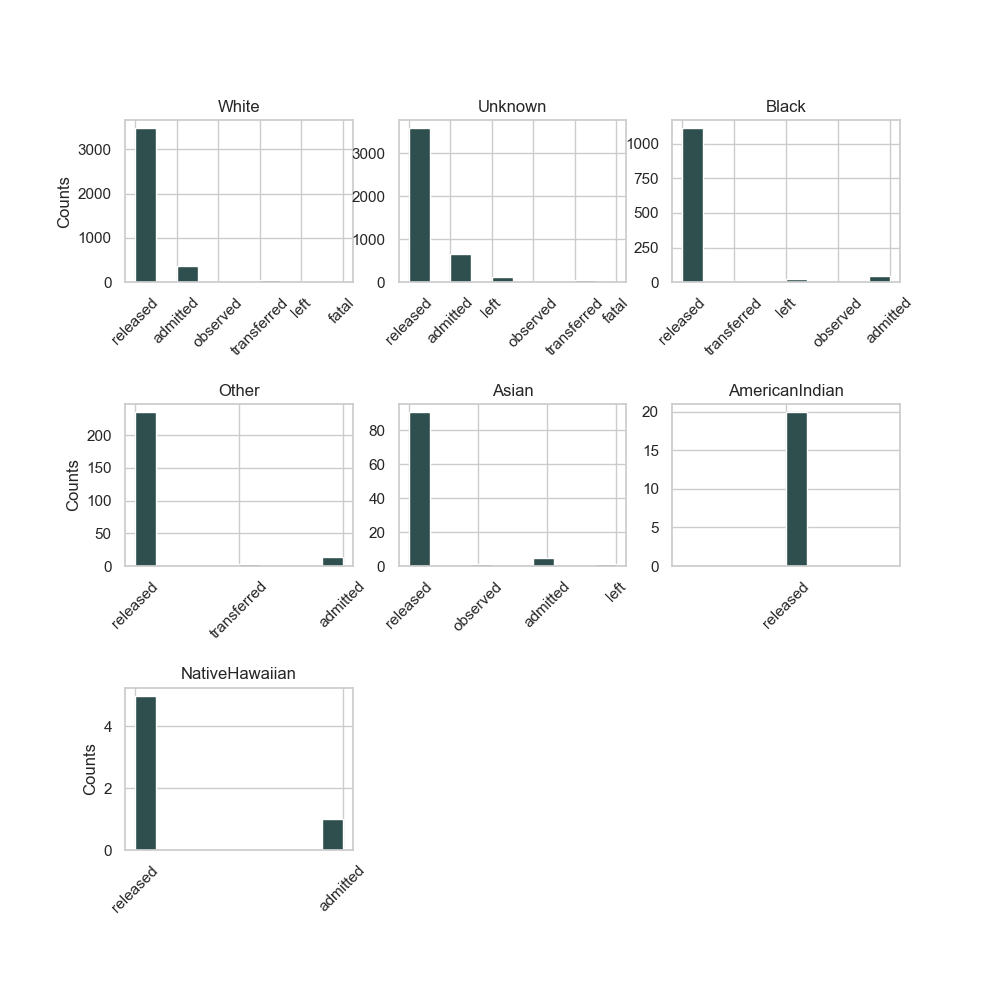

In [1081]:
grouped = df.groupby('Race')

figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(3, 3, 1) # Subplots with 3 rows and 3 columns, and current axis is the 1st subplot axes
axes.hist(grouped['Disposition'].get_group('White'),color="darkslategray", density=False)
axes.set_title('White')
plt.xticks(rotation=45)
axes.set_ylabel('Counts')

axes = figure.add_subplot(3, 3, 2) # Subplots with 3 rows and 3 columns, and current axis is the 2nd subplot axes
axes.hist(grouped['Disposition'].get_group('Unknown'),color="darkslategray", density=False)
axes.set_title('Unknown')
plt.xticks(rotation=45)

axes = figure.add_subplot(3, 3, 3)
axes.hist(grouped['Disposition'].get_group('Black'),color="darkslategray", density=False)
axes.set_title('Black')
plt.xticks(rotation=45)

axes = figure.add_subplot(3, 3, 4)
axes.hist(grouped['Disposition'].get_group('Other'),color="darkslategray", density=False)
axes.set_title('Other')
plt.xticks(rotation=45)
axes.set_ylabel('Counts')

axes = figure.add_subplot(3, 3, 5)
axes.hist(grouped['Disposition'].get_group('Asian'),color="darkslategray", density=False)
axes.set_title('Asian')
plt.xticks(rotation=45)

axes = figure.add_subplot(3, 3, 6)
axes.hist(grouped['Disposition'].get_group('AmericanIndian'),color="darkslategray", density=False)
axes.set_title('AmericanIndian')
plt.xticks(rotation=45)

axes = figure.add_subplot(3, 3, 7)
axes.hist(grouped['Disposition'].get_group('NativeHawaiian'),color="darkslategray", density=False)
axes.set_title('NativeHawaiian')
plt.xticks(rotation=45)
axes.set_ylabel('Counts')

plt.subplots_adjust(hspace = 0.75, bottom = 0.15)
plt.show()


#### Disposition vs. Location

In [1082]:
location_disposition = pd.crosstab(df['Location'], df['Disposition']);
location_disposition

Disposition,admitted,fatal,left,observed,released,transferred
Location,,,,,,
Farm_Ranch,0,0,0,0,1,0
Home,705,7,69,42,4198,71
IndustrialPlace,0,0,0,0,1,0
MobileHome,1,0,0,0,2,0
PublicProperty,133,1,7,2,583,13
School,11,0,5,0,409,1
SportRelated,52,1,11,1,922,5
Street_Highway,22,0,3,1,89,1
Unknown,176,0,75,22,2335,21


Similary, we are not able to determine anything useful from disposition versus location. The distribution of disposition in different locaitons seems the same as the distribution of locaiton itself. We do not see any obvious correlations between locations and disposition.

#### Disposition vs. Fire_Involvement

In [1083]:
fire_disposition = pd.crosstab(df['Fire_Involvement'], df['Disposition']);
fire_disposition

Disposition,admitted,fatal,left,observed,released,transferred
Fire_Involvement,,,,,,
NoFire,1085,9,167,67,8495,108
YesFire,15,0,3,1,45,4


The percentages of fire involvement are very small in all categories of disposition, suggesting that disposition was not significantly affected by fire involvement.

Next, we will figure out the relationships between independent variables.

#### Age vs. Sex

<IPython.core.display.Javascript object>


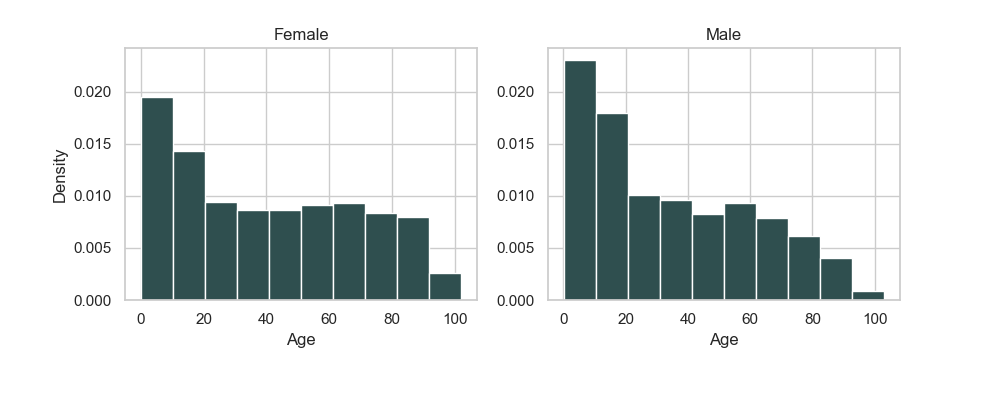

In [1084]:
grouped = df.groupby('Sex')

figure = plt.figure(figsize=(10, 4))

axes = figure.add_subplot(1, 2, 1) 
axes.hist(grouped['Age'].get_group('Female'), color='darkslategray', density=True)
axes.set_title('Female')
axes.set_xlabel('Age')
axes.set_ylabel('Density')

axes = figure.add_subplot(1, 2, 2, sharey = axes)
axes.hist(grouped['Age'].get_group('Male'), color='darkslategray', density=True)
axes.set_title('Male')
axes.set_xlabel('Age')

plt.subplots_adjust(bottom = 0.25)
plt.show()


<IPython.core.display.Javascript object>


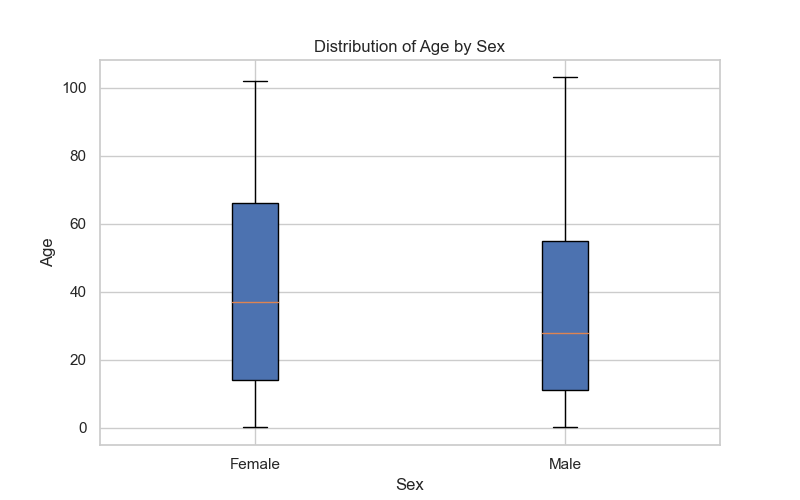

In [1085]:
figure = plt.figure(figsize = (8, 5))
axes = figure.add_subplot(1,1,1)
grouped = df.groupby('Sex')
labels = df['Sex'].unique()
labels = np.sort(labels)
grouped_data = [grouped['Age'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)

axes.set_xlabel('Sex')
axes.set_ylabel('Age')
axes.set_title('Distribution of {0} by {1}'.format('Age', 'Sex'))

plt.show()

The distributions of age in both male and female are right skewed. It is interesting to see that there were more young men getting injured than young women, but more women got injured at 60s and older. This may be an useful informaiton.

#### Age vs. Race

<IPython.core.display.Javascript object>


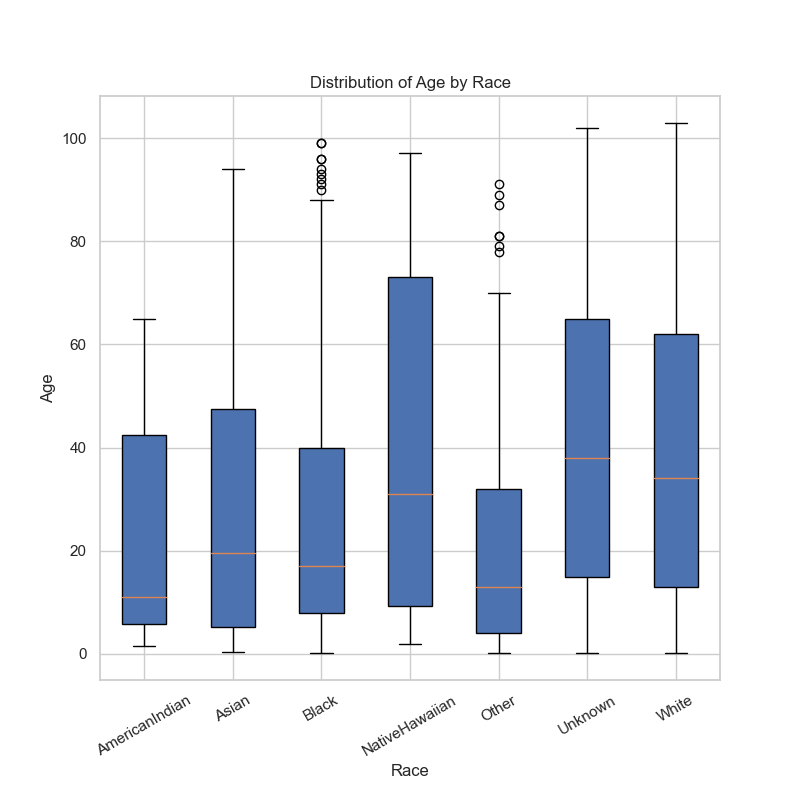

In [1086]:
figure = plt.figure(figsize = (8, 8))
axes = figure.add_subplot(1,1,1)
grouped = df.groupby('Race')
labels = df['Race'].unique()
labels = np.sort(labels)
grouped_data = [grouped['Age'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)

axes.set_xlabel('Race')
axes.set_ylabel('Age')
axes.set_title('Distribution of {0} by {1}'.format('Age', 'Race'))
plt.xticks(rotation=30)
plt.subplots_adjust(bottom = 0.15)

plt.show()

'NativeHawaiian', 'Unknown', 'White' show higher medians of injury age than other races. This may be another useful information.

#### Age vs. Location

<IPython.core.display.Javascript object>


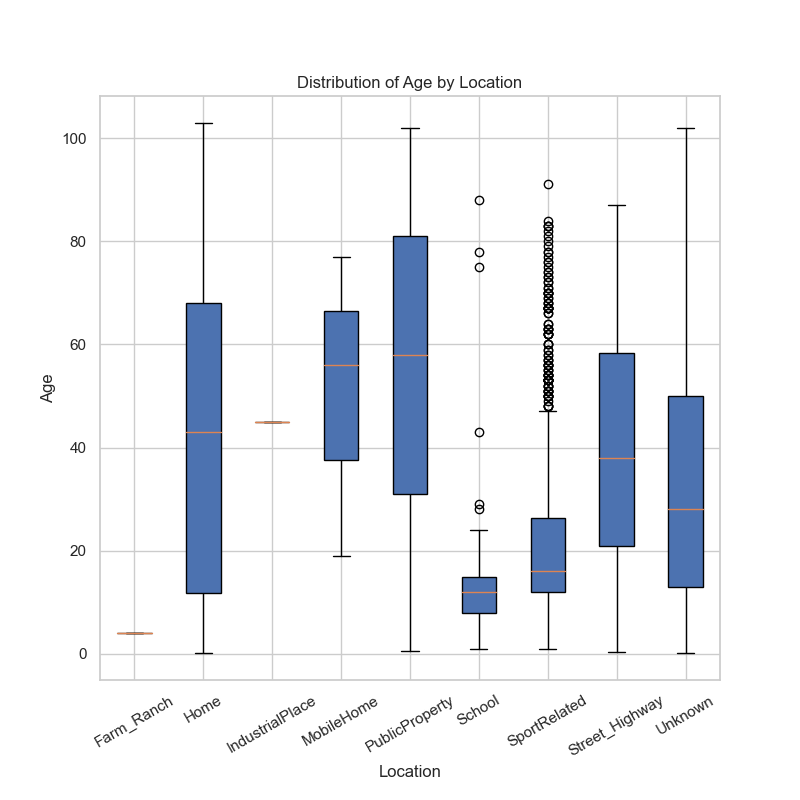

In [1087]:
figure = plt.figure(figsize = (8, 8))
axes = figure.add_subplot(1,1,1)
grouped = df.groupby('Location')
labels = df['Location'].unique()
labels = np.sort(labels)
grouped_data = [grouped['Age'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)

axes.set_xlabel('Location')
axes.set_ylabel('Age')
axes.set_title('Distribution of {0} by {1}'.format('Age', 'Location'))
plt.xticks(rotation=30)
plt.subplots_adjust(bottom = 0.15)

plt.show()


In [1088]:
df['Location'].value_counts()

Home               5092
Unknown            2629
SportRelated        992
PublicProperty      739
School              426
Street_Highway      116
MobileHome            3
IndustrialPlace       1
Farm_Ranch            1
Name: Location, dtype: int64

Injuries at 'Home' has the broadest range here, as does those that occurred in 'PublicProperty'. "Street_Highway' and 'Unknown' are close second. 'SportsRelated' injuries happen typically under 20, but can extend into the 40s. 'School' injuries basically stopp after 22-23. There is only one entry for 'Farm_Ranch' injury and 'IndustrialPlace' injury, respectively, we cannot get too much useful information from there. The same to 'MobileHome' injuries, only 3 entried cannot tell us too much.

#### Age vs. Fire_Involvement

<IPython.core.display.Javascript object>


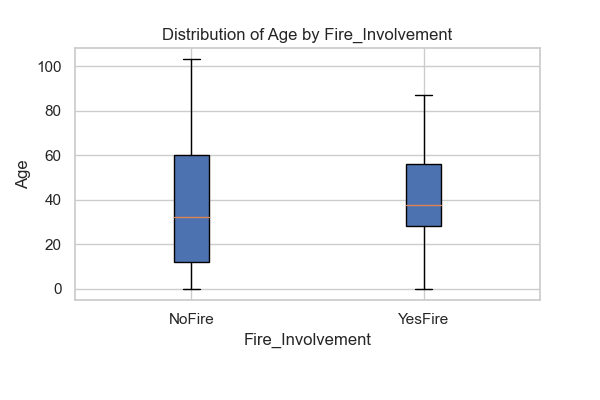

In [1089]:
figure = plt.figure(figsize = (6, 4))
axes = figure.add_subplot(1,1,1)
grouped = df.groupby('Fire_Involvement')
labels = df['Fire_Involvement'].unique()
labels = np.sort(labels)
grouped_data = [grouped['Age'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)

axes.set_xlabel('Fire_Involvement')
axes.set_ylabel('Age')
axes.set_title('Distribution of {0} by {1}'.format('Age', 'Fire_Involvement'))
plt.subplots_adjust(bottom = 0.25)

plt.show()

This is not surprised. The medians of two groups are just slightly different. Overall there is no significant difference between NoFire and YesFire groups.

<IPython.core.display.Javascript object>


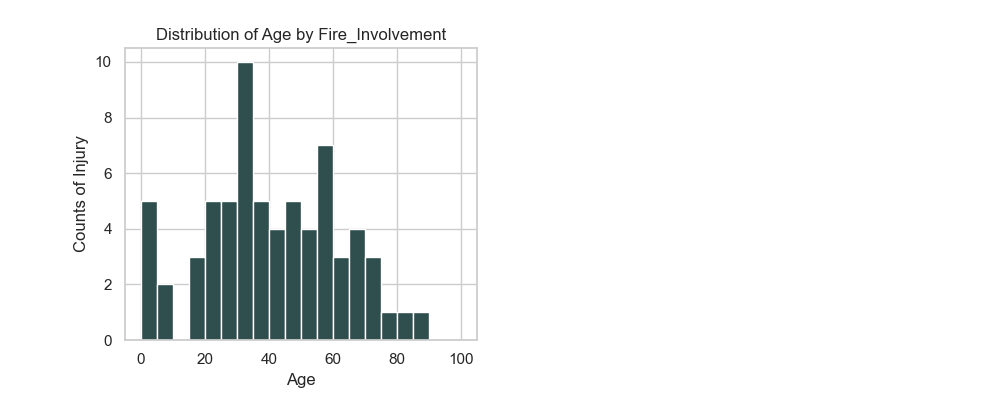

In [1090]:
yesfire_age = injuries[df['Fire_Involvement']=='YesFire']

mn = int(df.Age.min())
mx = int(df.Age.max())
bins = [i for i in range(mn, mx, 5)]

figure = plt.figure(figsize = (10, 4))
axes = figure.add_subplot(1,2,1)
axes.hist(yesfire_age.Age, color='darkslategray', bins = bins)
axes.set_title('Distribution of {0} by {1}'.format('Age', 'Fire_Involvement'))
plt.ylabel('Counts of Injury')
plt.xlabel('Age')

plt.subplots_adjust(bottom = 0.15)

plt.show()

With respect to the injuries with fire involved, lower ages tend to have a spike in fire related injuries but then drops in the teen years. Interestingly, the trend then spikes back up in early 30s where fire involvements are more common.

#### Sex vs. Race

In [1091]:
sex_race = pd.crosstab(df['Race'], df['Sex'])
sex_race

Sex,Female,Male
Race,,
AmericanIndian,11,9
Asian,47,51
Black,560,636
NativeHawaiian,2,4
Other,123,130
Unknown,2182,2288
White,1933,2023


<IPython.core.display.Javascript object>


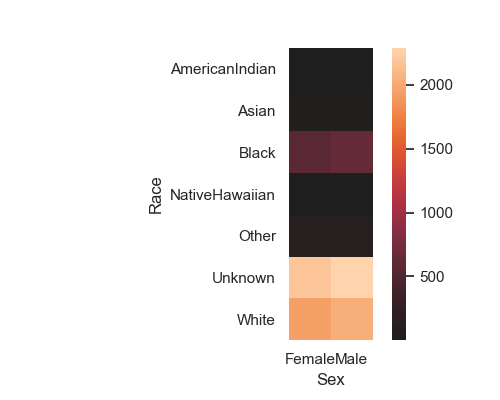

In [1092]:
figure = plt.figure(figsize = (5, 4))
figure = sns.heatmap(sex_race, center = True, square = True)
plt.subplots_adjust(bottom = 0.15)

From the heatmap we observe that 'White' and 'Black' men and those men of 'Unknown' race these are more pronounced than women, whereas there are no obvious differences between men and women in all the other races.

#### Sex vs. Location

In [1093]:
sex_location = pd.crosstab(df['Location'], df['Sex'])
sex_location

Sex,Female,Male
Location,,
Farm_Ranch,0,1
Home,2679,2413
IndustrialPlace,0,1
MobileHome,0,3
PublicProperty,395,344
School,164,262
SportRelated,363,629
Street_Highway,49,67
Unknown,1208,1421


It seems that males are 10% and 15% less likely to be injured at 'Home' and 'PublicProperty', but rather at other places, such as school, sport related places, and Street/Highway.

#### Race vs. Location

In [1094]:
race_location = pd.crosstab(df['Race'], df['Location'])
race_location

Location,Farm_Ranch,Home,IndustrialPlace,MobileHome,PublicProperty,School,SportRelated,Street_Highway,Unknown
Race,,,,,,,,,
AmericanIndian,0,10,0,0,1,1,1,0,7
Asian,0,51,0,0,5,4,11,1,26
Black,0,467,0,1,55,91,136,8,438
NativeHawaiian,0,3,0,0,2,0,0,0,1
Other,0,117,0,0,16,8,50,1,61
Unknown,0,2261,0,0,391,162,400,79,1177
White,1,2183,1,2,269,160,394,27,919


Not really any interesting patterns here. The injury distribution of different races at different locaitons is almost the same as the distribution of locaiton itself. That is, most people injured at home, with 'White', 'Black' and 'Unknown' people having the most injuries at all places. So locaiton doesn't seems to be related to race.

#### Location vs. Fire_Involvement

In [1095]:
location_fire = pd.crosstab(df['Location'], df['Fire_Involvement'])
location_fire

Fire_Involvement,NoFire,YesFire
Location,,
Farm_Ranch,1,0
Home,5035,57
IndustrialPlace,1,0
MobileHome,1,2
PublicProperty,739,0
School,426,0
SportRelated,992,0
Street_Highway,116,0
Unknown,2620,9


<IPython.core.display.Javascript object>


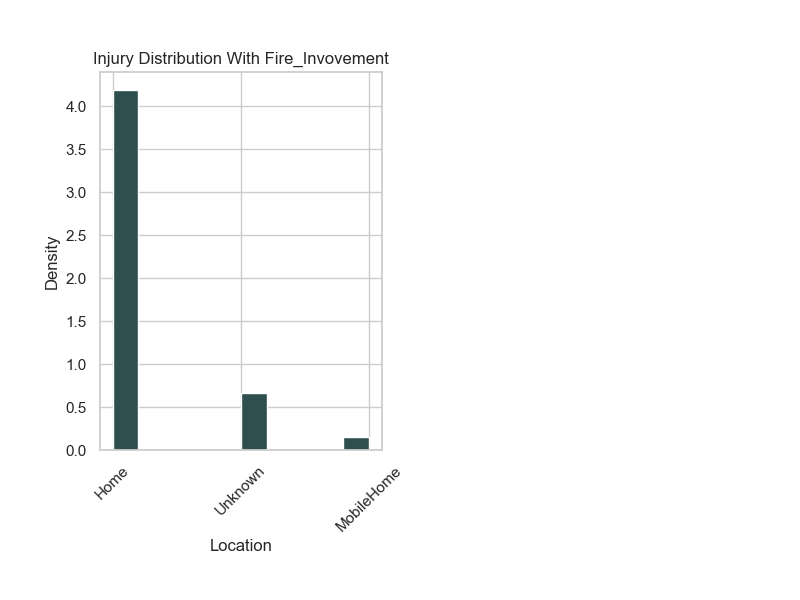

In [1096]:
grouped = df.groupby('Fire_Involvement')

figure = plt.figure(figsize=(8, 6))
axes = figure.add_subplot(1, 2, 1) 
axes.hist(grouped['Location'].get_group('YesFire'), color='darkslategray', density=True)
axes.set_title('Injury Distribution With Fire_Invovement')
axes.set_xlabel('Location')
axes.set_ylabel('Density')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom = 0.25)

plt.show()

The data shows that 'Home' is the place that affeced most by fires, 'Unknown' and 'MobileHome' are the second ones. Other locations were not affected by fire at all in this dataset. So I don't think there is a relationship between 'Location' and 'Fire_Involvement'.

## Logistic Modeling Regression

In [1097]:
import models as models

Based on above EDA, I would believe that a logistic regression might be suitable for these data. So for the dependent variable 'Disposition', let's encode a binary variable for surival and fatality.

In [1098]:
df.Disposition.unique()

array(['released', 'admitted', 'transferred', 'left', 'observed', 'fatal'],
      dtype=object)

In [1099]:
disposition_values = {'released': 'Survived', 'admitted': 'Survived', 'transferred': 'Survived', 
                      'left': 'Fatal', 'observed': 'Fatal', 'fatal': 'Fatal'}
df['Disposition'] = df['Disposition'].replace(disposition_values)

In [1100]:
eda.variable_details(df.Disposition);

Disposition,Count,Frequency (%)
Survived,9752,97.529753
Fatal,247,2.470247


Clearly, the data is heavily skewed for survival of patients. This may drive the regression to have reduced meaning if there is such a small (2.5%) in the second category. We will evaluate the data nonetheless.

Next let us add dummy variables for our first logistic model attempt.

In [1101]:
df = pd.concat([df, pd.get_dummies(df['Sex'])], axis=1).drop(columns='Sex')
df = pd.concat([df, pd.get_dummies(df['Race'], prefix='Race')], axis=1).drop(columns='Race')
df = pd.concat([df, pd.get_dummies(df['Location'], prefix='Location')], axis=1).drop(columns='Location')
df = pd.concat([df, pd.get_dummies(df['Disposition'])], axis=1).drop(columns='Disposition')
df = df.drop('Fatal', axis=1)

In [1102]:
df['Fire_Involvement'] = df['Fire_Involvement'].replace({'YesFire':1, 'NoFire':0})
df = df.rename(columns = {'Fire_Involvement': 'Fire'})

In [1103]:
df.info();
df.sample(10).transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       9999 non-null   float64
 1   Fire                      9999 non-null   int64  
 2   Female                    9999 non-null   uint8  
 3   Male                      9999 non-null   uint8  
 4   Race_AmericanIndian       9999 non-null   uint8  
 5   Race_Asian                9999 non-null   uint8  
 6   Race_Black                9999 non-null   uint8  
 7   Race_NativeHawaiian       9999 non-null   uint8  
 8   Race_Other                9999 non-null   uint8  
 9   Race_Unknown              9999 non-null   uint8  
 10  Race_White                9999 non-null   uint8  
 11  Location_Farm_Ranch       9999 non-null   uint8  
 12  Location_Home             9999 non-null   uint8  
 13  Location_IndustrialPlace  9999 non-null   uint8  
 14  Location

,2331,6572,4742,4848,190,2981,9243,9149,3476,3002
Age,1.333333,48.0,53.0,23.0,2.0,82.0,80.0,80.0,2.0,73.0
Fire,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Female,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Male,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Race_AmericanIndian,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Race_Asian,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Race_Black,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Race_NativeHawaiian,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Race_Other,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Race_Unknown,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


Now the dataset looks neat.

### Logistic Model 1: survival versus age, sex, race and fire

First, we'll start out by applying a logistic regression model against the binary switch target for survival.

In [1104]:
formula1 = 'Survived ~ Age + Fire + Female + Race_AmericanIndian + Race_Asian + Race_Black + Race_Other + Race_Unknown + Race_White'
result1 = models.logistic_regression(formula1, df)
models.simple_describe_lgr(result1)

In [1105]:
print('adjusted R^2: {:.5f}'.format(models.adjusted_r_squared(result1)))

adjusted R^2: 0.00382


In [1106]:
result1_2 = models.bootstrap_logistic_regression(formula1, df)
models.describe_bootstrap_lgr(result1_2)

In [1107]:
print('Bootstrap logistic adjusted R^2: {:.5f}'.format(models.adjusted_r_squared(result1_2)))

Bootstrap logistic adjusted R^2: 0.00382


Unfortunately, the logistic regression is very bad fitting of the data. The $R^2$ and adjusted $R^2$ values appear very low, however the error rate is not terrible. It's possible that more features are needed with a varying relationship to the target variable.

Next, we'll add the 9 injury locations to the formula.

### Logistic Model 2: survival versus age, sex, race and location

Now we are adding injury locations to see how that improves the logistic model.

In [1108]:
formula2 = 'Survived ~ Age + Fire + Female + Race_AmericanIndian + Race_Asian + Race_Black + Race_Other + Race_Unknown + Race_White + Location_Farm_Ranch + Location_Home + Location_IndustrialPlace + Location_MobileHome + Location_PublicProperty + Location_School + Location_SportRelated + Location_Street_Highway + Location_Unknown'
result2 = models.logistic_regression(formula2, df)
models.simple_describe_lgr(result2)

In [1109]:
print('adjusted R^2: {:.5f}'.format(models.adjusted_r_squared(result2)))

adjusted R^2: 0.00670


In [1110]:
result2_2 = models.bootstrap_logistic_regression(formula2, df)
models.describe_bootstrap_lgr(result2_2)

In [1111]:
print('Bootstrap logistic adjusted R^2: {:.5f}'.format(models.adjusted_r_squared(result2_2)))

Bootstrap logistic adjusted R^2: 0.00670


We can see that the model only improved marginally, the $R^2$ and adjusted $R^2$ scores are still terrible. We do note that some features included in the data set are not very appropriate with text-based entries associates to dozens of categories. These features prove very difficult to encode in the model. 

### Cross Validation

We are going to apply cross validation to obtain mean scoring for the Logistic regression on test data.

In [1112]:
feature_columns = df.columns[df.columns != 'Survived'] #Getting all the Xs
X = df[feature_columns]
Y = df['Survived']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25) # test_size represents the proportion of the dataset to include in the test split

In [1113]:
feature_columns

Index(['Age', 'Fire', 'Female', 'Male', 'Race_AmericanIndian', 'Race_Asian',
       'Race_Black', 'Race_NativeHawaiian', 'Race_Other', 'Race_Unknown',
       'Race_White', 'Location_Farm_Ranch', 'Location_Home',
       'Location_IndustrialPlace', 'Location_MobileHome',
       'Location_PublicProperty', 'Location_School', 'Location_SportRelated',
       'Location_Street_Highway', 'Location_Unknown'],
      dtype='object')

In [1114]:
np.random.seed([12345])

regr = LogisticRegression().fit(X_train, Y_train)
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
log_scores = cross_val_score(regr, X_train, Y_train, cv=cv, n_jobs=-1)
print("Log Regression Accuracy: %0.3f (+/- %0.2f)" % (log_scores.mean(), log_scores.std() * 2))
print(log_scores)

Log Regression Accuracy: 0.974 (+/- 0.01)
[0.97013333 0.9808     0.97333333 0.96533333 0.97866667 0.97333333
 0.97493333 0.976      0.968      0.9792    ]


Surprisingly, we do not see a variation in the logistic model scoring. These values for cross validation are a little unnerving since we didn't see high scores on the bootstrap model. 

Apparently it shows  strong model performance but could be indicative that features are not properly classifying the survival feature. Also at play is the fact that a very high percentage (~97.5%) of data is survival so the logistic model is shown to be capable of determining survival rate. Next, we'll visualize this with learning curves.

### Learning Curve

<IPython.core.display.Javascript object>


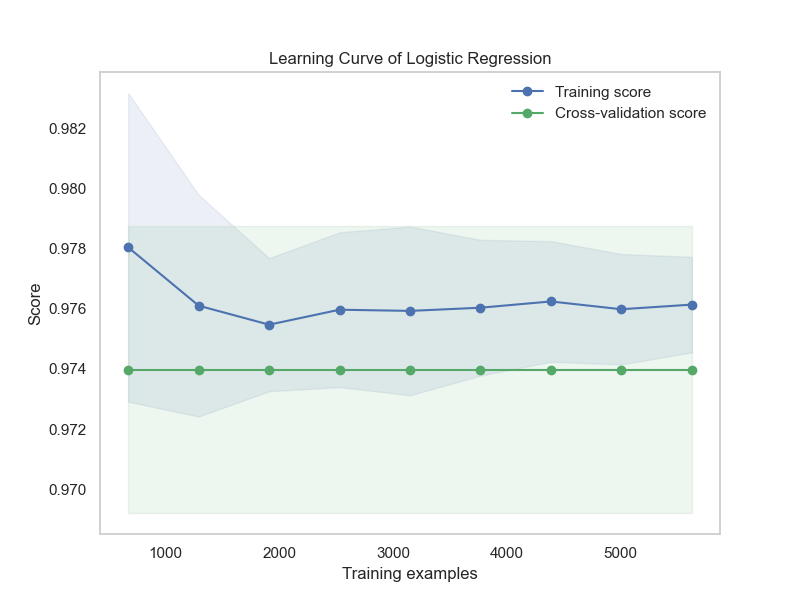

In [1177]:
fig, ax = plt.subplots(figsize=(8,6))
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(regr, X_train, Y_train, n_jobs=-1, shuffle=True, 
                                                        train_sizes=np.linspace(0.01, 1, 10), cv=cv)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve of Logistic Regression')
plt.legend(loc='best')
plt.xlabel('Training examples', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid()
plt.show()

The learning curve tells us that getting more data will not improve the fit too much. Evidently, the logistic fit scores very high. This can potentially be attributed to overfitting and lack of meaningful or distributed target variables. The classification of the target binary variable is clearly accomplished, however does this imply meaning when the target variable is >97% the same result?

Next, let us move on to test other methods with ML techniques, which will hopefully prove to be more robust modeling results.

## KNN (K-Nearest Neighbors) Classification

In [1146]:
np.random.seed([123456])

param_range = np.arange(1,10)
knnscores = []
for k in param_range:
    knnRgr = KNeighborsClassifier(k, n_jobs=-1)
    knnRgr.fit(X_train, Y_train)
    score = knnRgr.score(X_test, Y_test)
    print(k, score)
    knnscores.append(score)

1 0.9472
2 0.926
3 0.9708
4 0.9636
5 0.9744
6 0.9744
7 0.9744
8 0.9736
9 0.9744


Let us plot a validation curve to determine the appropriate estimate for K.

<IPython.core.display.Javascript object>


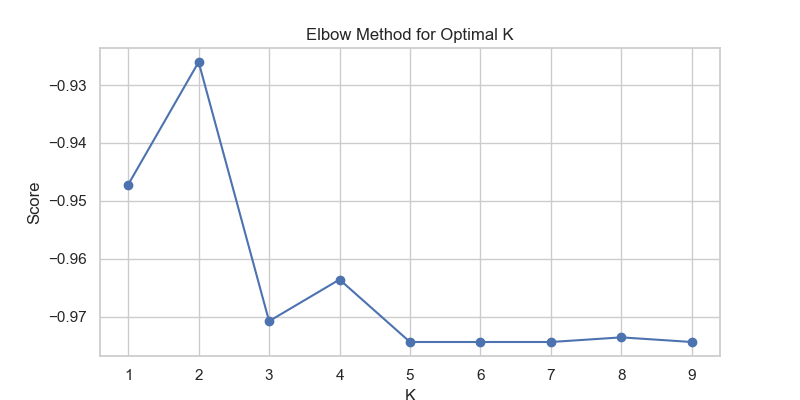

In [1147]:
knnscores = [i*-1 for i in knnscores]
xs = param_range
figure = plt.figure(figsize=(8, 4))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, knnscores, 'o-', color='b')

axes.set_title('Elbow Method for Optimal K')
plt.xlabel(r'K', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.show()

Using the elbow-method, we can approximate the optimal number for K to be 2.

In [1148]:
model = KNeighborsClassifier(n_neighbors=2)
knnscores = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy', n_jobs=-1) #Run 10-fold cross validation
print("KNN (K=2) Model Accuracy: %0.3f (+/- %0.2f)" % (knnscores.mean(), knnscores.std() * 2))
print(r"95% CI for R^2:", stats.mstats.mquantiles(knnscores, [0.025, 0.975]))

KNN (K=2) Model Accuracy: 0.937 (+/- 0.01)
95% CI for R^2: [0.924      0.94266667]


So running 10 fold cross validation on KNN with K=2 gives us ~94% accuracy which is very strong.

In [1119]:
def bootstrap_sample(data, f, n=100):
    result = []
    m = len(data)
    for _ in range(n):
        sample = np.random.choice(data, len(data), replace=True)
        r = f(sample)
        result.append(r)
    return np.array(result)

<IPython.core.display.Javascript object>


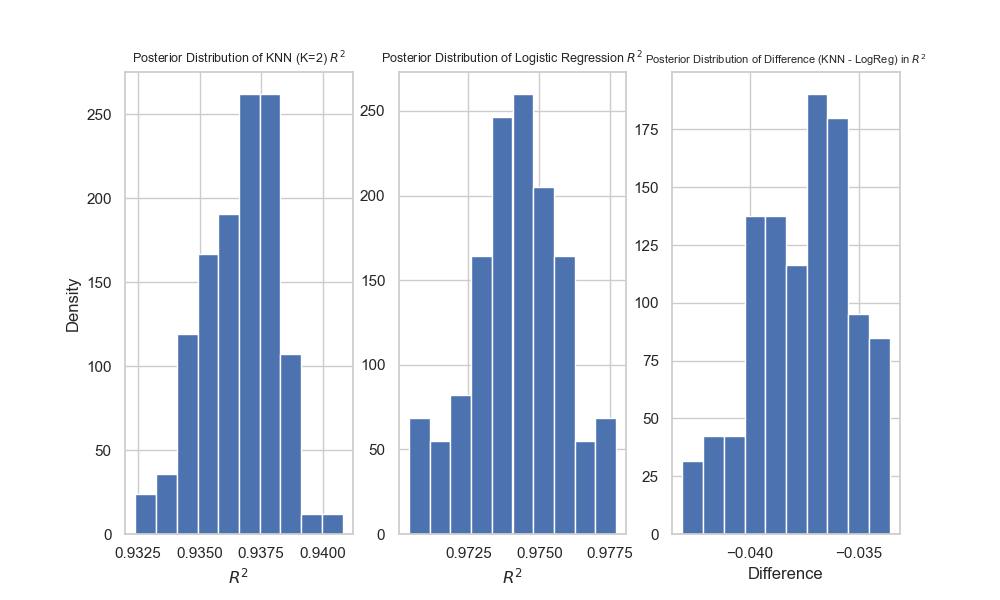

In [1178]:
log_bs = bootstrap_sample(log_scores, np.mean)
knn_bs = bootstrap_sample(knnscores, np.mean)
difference = knn_bs - log_bs

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 3, 1)
axes.hist(knn_bs, density=True)
axes.set_ylabel('Density')
axes.set_xlabel('$R^2$')
axes.set_title('Posterior Distribution of KNN (K=2) $R^2$', fontsize=9)

axes = figure.add_subplot(1, 3, 2)
axes.hist(log_bs, density=True)
axes.set_xlabel('$R^2$')
axes.set_title('Posterior Distribution of Logistic Regression $R^2$', fontsize=9)

axes = figure.add_subplot(1, 3, 3)
axes.hist(difference, density=True)
axes.set_xlabel('Difference')
axes.set_title('Posterior Distribution of Difference (KNN - LogReg) in $R^2$', fontsize=8)

plt.show()

In [1121]:
print('P(KNN > LogRgr): {:.3f}'.format( np.mean(difference > 0)))

P(KNN > LogRgr): 0.000


According to the bootstrap resampling we can see that there is no chance that the KNN method would exceed the logistic regression. Next let us compare KNN with K-Means Clustering.

## K-Means Clustering

 First of all let us plot a validation curve to find an optimal K value.

In [1201]:
km_scores = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_train)
    score = kmeans.score(X_test, Y_test)
    km_scores.append(score)

<IPython.core.display.Javascript object>


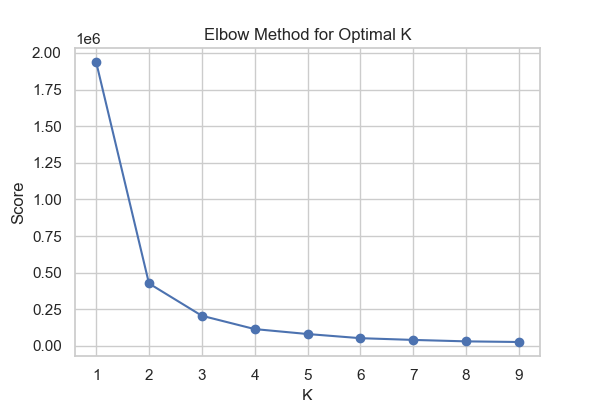

In [1202]:
km_scores = [i*-1 for i in km_scores]
xs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.plot( xs, km_scores, 'o-', color='b')

axes.set_title('Elbow Method for Optimal K')
plt.xlabel(r'K', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.show()

So Let's evaluate this with a K of 3 to see it's improvement over KNN.

In [1203]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
y_pred = kmeans.predict(X_test)
print(accuracy_score(Y_test, y_pred))

0.4056


So with a K value of 2 we can get a score of ~41%

In [1125]:
kmeans = KMeans(n_clusters=2, random_state=0)
km_scores = cross_val_score(kmeans, X_train, Y_train, cv=10, scoring='accuracy') #Run 10-fold cross validation
print('K-Means (K=2) Model Accuracy: %0.3f (+/- %0.2f)' % (km_scores.mean(), km_scores.std() * 2))
print(r'95% CI for R^2:', stats.mstats.mquantiles(km_scores, [0.025, 0.975]))

K-Means (K=2) Model Accuracy: 0.503 (+/- 0.16)
95% CI for R^2: [0.39866667 0.588     ]


We can see that the K-Means cross validation scores is lower than that of KNN but still a moderate

<IPython.core.display.Javascript object>


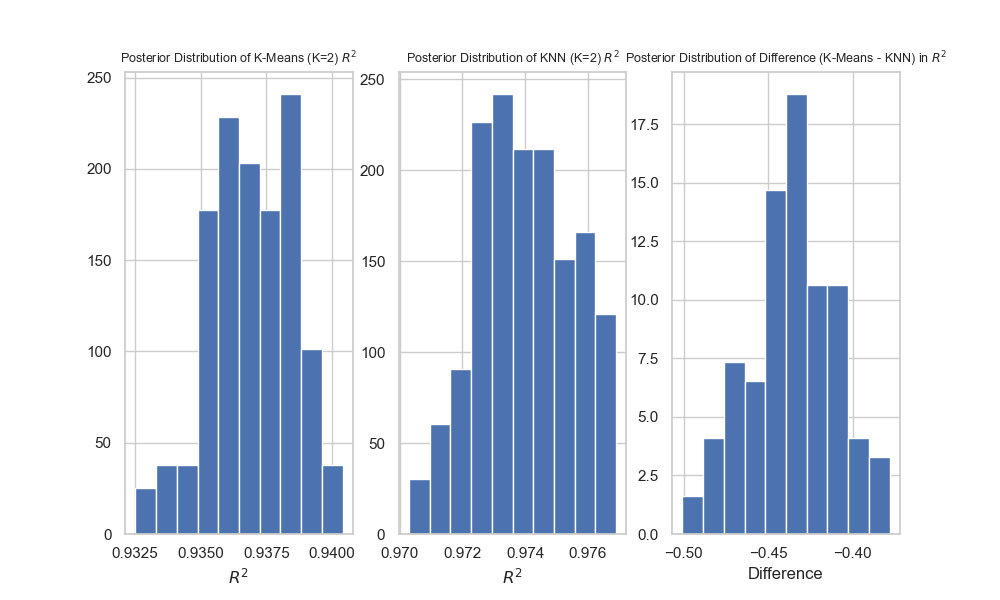

In [1155]:
kmeans_bs = bootstrap_sample(km_scores, np.mean)
knn_bs = bootstrap_sample(knnscores, np.mean)
difference = kmeans_bs - knn_bs

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 3, 1)
axes.hist(knn_bs, density=True)
axes.set_xlabel('$R^2$')
axes.set_title('Posterior Distribution of K-Means (K=2) $R^2$', fontsize=9)

axes = figure.add_subplot(1, 3, 2)
axes.hist(log_bs, density=True)
axes.set_xlabel('$R^2$')
axes.set_title('Posterior Distribution of KNN (K=2) $R^2$', fontsize=9)

axes = figure.add_subplot(1, 3, 3)
axes.hist(difference, density=True)
axes.set_xlabel('Difference')
axes.set_title('Posterior Distribution of Difference (K-Means - KNN) in $R^2$', fontsize=9)

plt.show()

In [1156]:
print('P(K-Means > KNN): {:.3f}'.format(np.mean(difference > 0)))

P(K-Means > KNN): 0.000


We didn't expect that the K-Means clustering would work very well with the classification data. The model only describes about 50% of the variability of the survival parameters. This is certainly lower than KNN mean score of above 90%.

We'll continue with some Rule Based models starting with Decision Tree.

## Decision Tree

In [1128]:
np.random.seed([1234])
param_range = np.arange(1,6)
dec_scores = []
for ii in param_range:
    decTree = tree.DecisionTreeClassifier(max_depth=ii)
    decTree.fit(X_train, Y_train)
    score = decTree.score(X_test, Y_test)
    print(ii, score)
    dec_scores.append(score)

1 0.9744
2 0.9744
3 0.9736
4 0.9736
5 0.9724


Here we see very little variation in the decision tree depth. Let's try a validation curve to see if it changes. We would expect that the decision tree may not work for this data since this data doesn't have large differences between the categories.

<IPython.core.display.Javascript object>


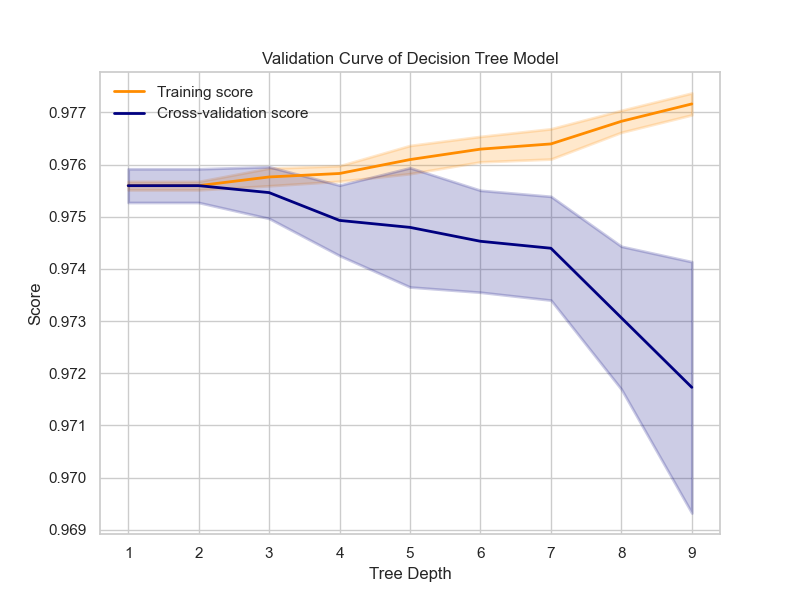

In [1207]:
np.random.seed([1234])
param_range = np.arange(1,10)
train_scores, valid_scores = validation_curve(decTree, X_train, Y_train, 'max_depth', param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

fig, ax = plt.subplots(figsize=(8,6))
lw = 2
plt.plot(param_range, train_scores_mean, label='Training score', color='darkorange', lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color='darkorange', lw=lw)
plt.plot(param_range, valid_scores_mean, label='Cross-validation score', color='navy', lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, 
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color='navy', lw=lw)
plt.legend(loc='best')
plt.title('Validation Curve of Decision Tree Model')
plt.xlabel(r'Tree Depth', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True)
plt.show()

Interesting validation curves. We see that the validation results are initially converged but then as the tree depth increases further they diverge from the training result. It seems that the model is overfitted here and that a lower score is desired.

Let's try to visualize the decision tree model.

<IPython.core.display.Javascript object>


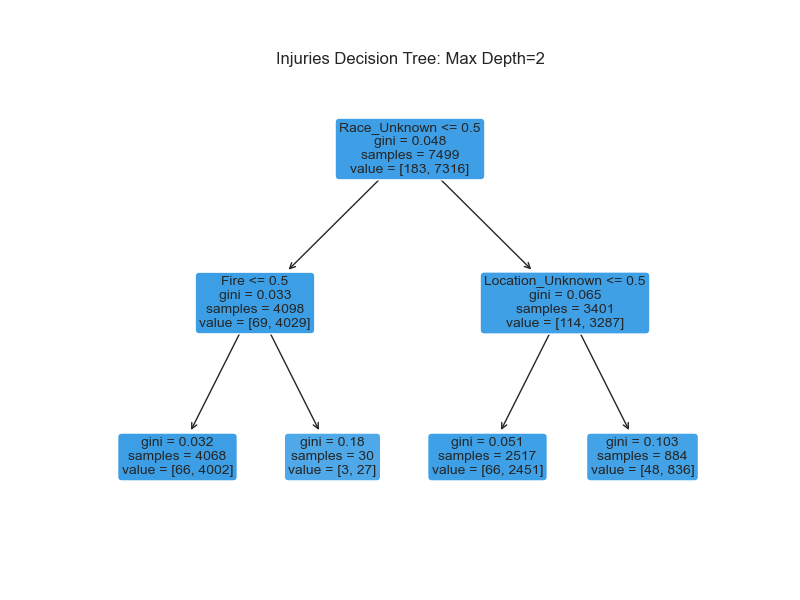

In [1214]:
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

fig, ax = plt.subplots(figsize=(8,6))
tree.plot_tree(clf, filled=True, feature_names=features, rounded=True, ax=ax, fontsize=10);
plt.title('Injuries Decision Tree: Max Depth=2', fontsize=12)
plt.show()

Once again with the Decision Tree classification, there are very high scoring results due to the large percentage of survival categories. 

## Random Forest

Next, let's try random forest. I doubt random forest regression will yield any decent results, but let's try it anyway, and then let's try random forest classification as something that might generate some decent results.

### Random Forest Regression

In [1172]:
clf = RandomForestRegressor()
clf = clf.fit(X_train, Y_train)
tmp = clf.score(X_test, Y_test)
print('Random Forest Regression: {:.3f}'.format(tmp))

Random Forest Regression: -0.217


In [1173]:
# referred from sklearn docs https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

param_range = np.arange(1,15)
train_scores, valid_scores = validation_curve(RandomForestRegressor(), X_train, Y_train, 'max_depth', 
                                              param_range=param_range)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

<IPython.core.display.Javascript object>


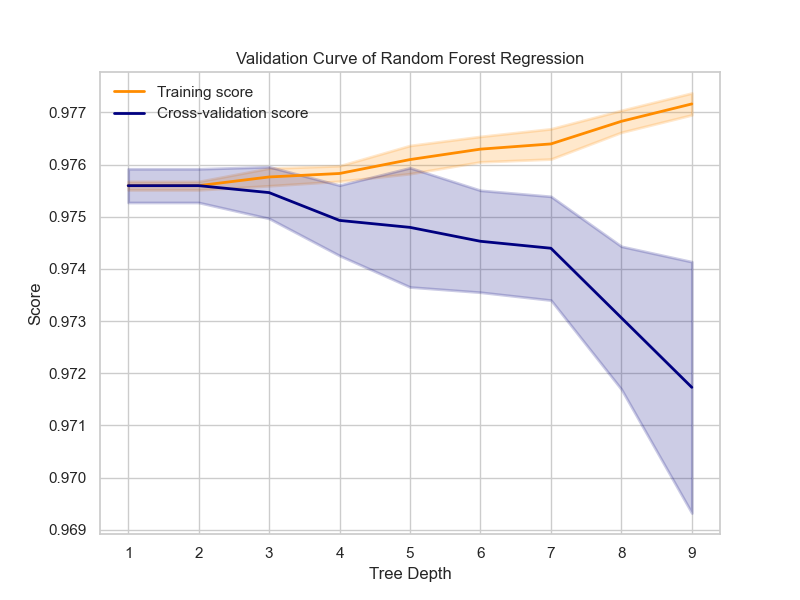

In [1215]:
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Validation Curve of Random Forest Regression')
plt.xlabel(r'$\k$')
plt.ylabel('Score')
lw = 2
plt.plot(param_range, train_scores_mean, label='Training score', color='darkorange', lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='darkorange', lw=lw)
plt.plot(param_range, valid_scores_mean, label='Cross-validation score', color='navy', lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color='navy', lw=lw)
plt.legend(loc='best')
plt.xlabel(r'Tree Depth', fontsize=12)
plt.grid(True)
plt.show()

In [1175]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(), X_train, Y_train, train_sizes=np.linspace(0.01, 1, num=10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

<IPython.core.display.Javascript object>


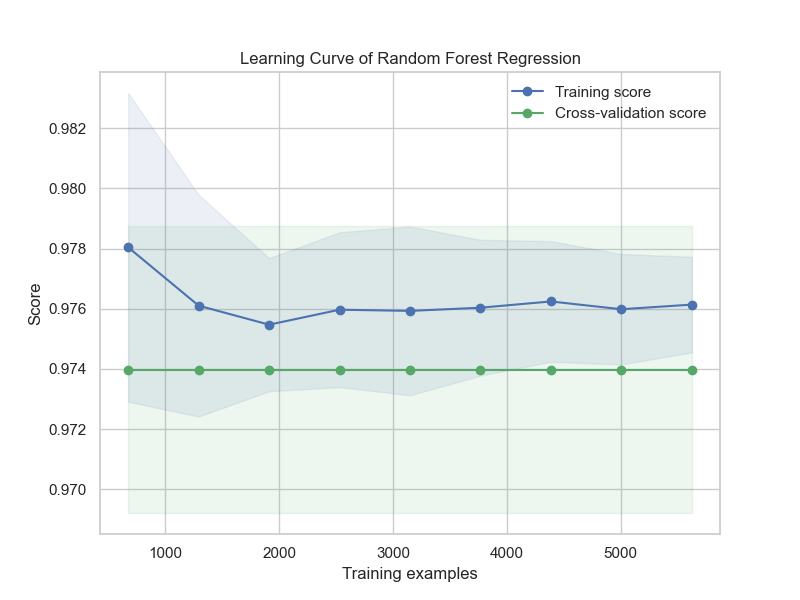

In [1179]:
fig, ax = plt.subplots(figsize=(8,6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")
plt.title('Learning Curve of Random Forest Regression')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Unsurprisingly, random foreset regression results in relatively useless model scores. The validation curve shows us extramely low scores and adding more data does not seem be helpful.

### Random Forest Classification

In [1181]:
# referred from sklearn docs https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

param_range = np.arange(1,15)
train_scores, valid_scores = validation_curve(RandomForestClassifier(), X_train, Y_train, 'max_depth', param_range=param_range)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

<IPython.core.display.Javascript object>


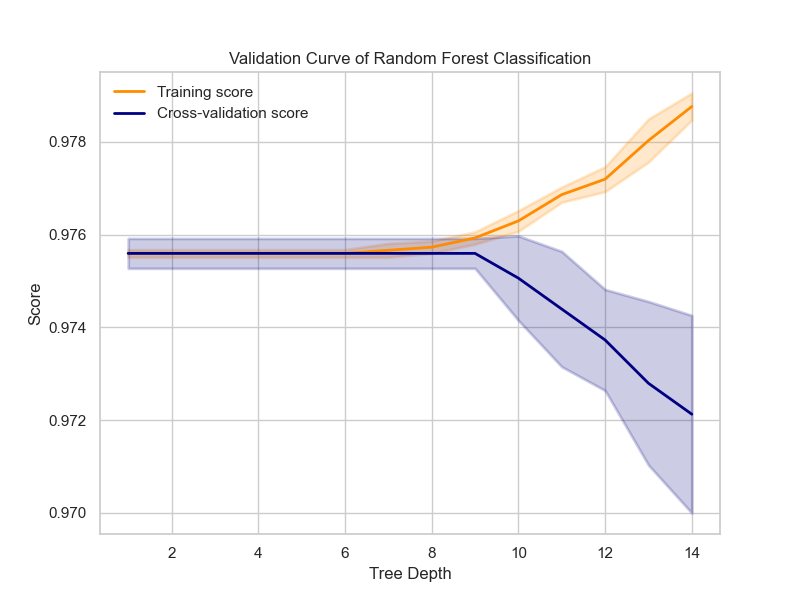

In [1182]:
fig, ax = plt.subplots(figsize=(8,6))
lw = 2
plt.plot(param_range, train_scores_mean, label='Training score', color='darkorange', lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='darkorange', lw=lw)
plt.plot(param_range, valid_scores_mean, label='Cross-validation score',  color='navy', lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color='navy', lw=lw)
plt.legend(loc='best')
plt.title('Validation Curve of Random Forest Classification')
plt.xlabel(r'Tree Depth', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True)
plt.show()

In [1184]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, Y_train, train_sizes=np.linspace(0.01, 1, num=10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

<IPython.core.display.Javascript object>


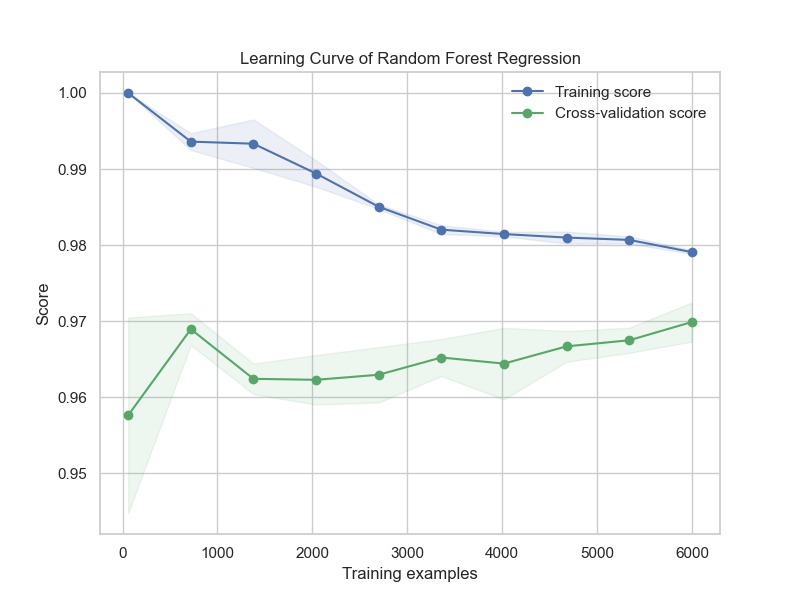

In [1186]:
fig, ax = plt.subplots(figsize=(8,6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve of Random Forest Regression')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Amazing fit from random forest classification! $R^2$ is above 0.97. Besides, adding more data might be helpful to improve the fit. So I'd use this algorithm for this dataset.

Let's test evaluation of the random forest with depth of 6 before we compare the final results against the KNN bootstrap.

In [1195]:
model = RandomForestClassifier(max_depth=6)
rf_scores = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
print('Random Forest Classification Model Accuracy (depth=6): %0.3f (+/- %0.2f)' % (rf_scores.mean(), rf_scores.std() * 2))
print(r'95% CI for R2:', stats.mstats.mquantiles(rf_scores, [0.025, 0.975]))

Random Forest Classification Model Accuracy (depth=6): 0.976 (+/- 0.00)
95% CI for R2: [0.97466667 0.976     ]


<IPython.core.display.Javascript object>


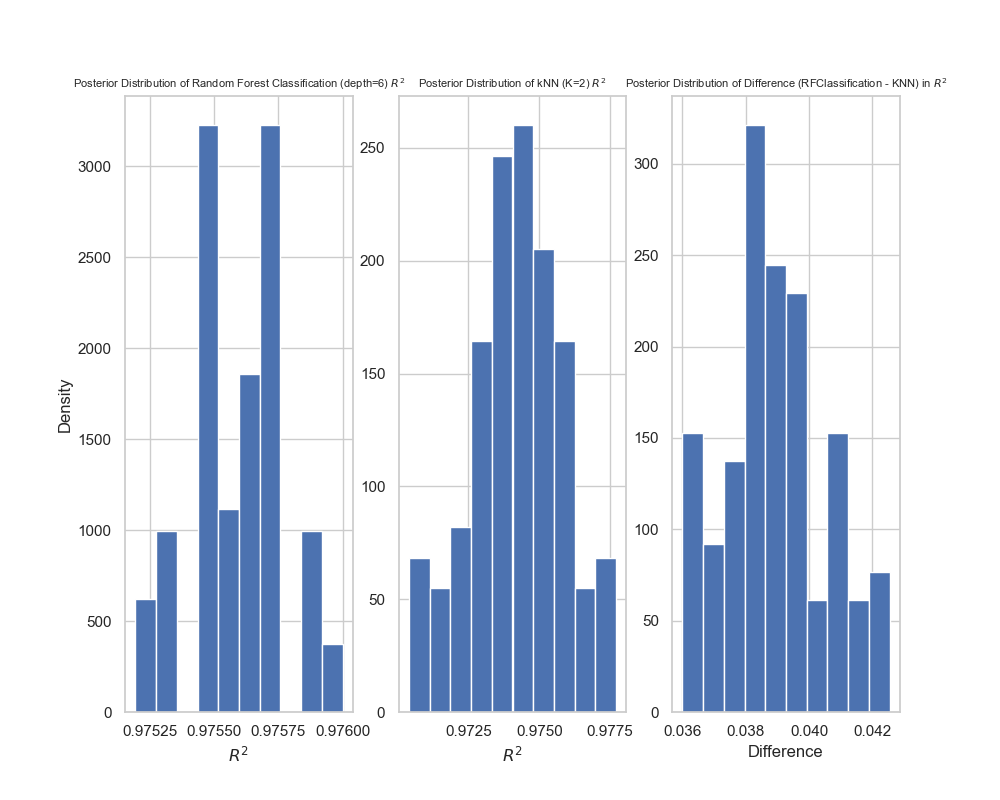

In [1191]:
rfclass_bs = bootstrap_sample(rf_scores, np.mean)
knn_bs = bootstrap_sample(knnscores, np.mean)
difference = rfclass_bs - knn_bs

figure = plt.figure(figsize=(10, 8))

axes = figure.add_subplot(1, 3, 1)
axes.hist(rfclass_bs, density=True)
axes.set_ylabel('Density')
axes.set_xlabel('$R^2$')
axes.set_title('Posterior Distribution of Random Forest Classification (depth=6) $R^2$', fontsize=8)

axes = figure.add_subplot(1, 3, 2)
axes.hist(log_bs, density=True)
axes.set_xlabel('$R^2$')
axes.set_title('Posterior Distribution of kNN (K=2) $R^2$', fontsize=8)

axes = figure.add_subplot(1, 3, 3)
axes.hist(difference, density=True)
axes.set_xlabel('Difference')
axes.set_title('Posterior Distribution of Difference (RFClassification - KNN) in $R^2$', fontsize=8)

plt.show()

In [1142]:
print('P(Random Forest Classification > kNN): {:.3f}'.format(np.mean(difference > 0)))

P(Random Forest Classification > kNN): 1.000


So both KNN and Random Forest Classification show great $R^2$, however Random Forest Classification seems more suitable for this dataset than KNN.

## Modeling Conclusion

Overall, the National Injury database structure is very complicated, with dozens of potential features for modeling making the selection process complex. And classifying categorical data based on both continuous and categorical variables is rather difficult. However, we did come up with some trends to reliable results. Since typical linear regression cannot be effectively used for this dataset, we tried logistic regression based on the transformation of a new dependent variable which is binary (1 or 0) survival. Unfortunately, the features for this data was too complicated to fit logistic regression reliably, and that did not yield productive results. 

In learning this, we decided next to move to machine learning techniques of both Distance and Rule based methods. We tried the K-Nearest Neighbors, K-Means Clustering, Random Forest Regression, and Random Forest Classification algorithms. Of those four methods, random forest regression failed spectacularly, with an R-squared value of far less than one. K-Means Clustering did rather will, with an overall $R^2$ of roughly 0.5 after appropriate fit parameters were discovered, but this paled in comparison to the last two. Both KNN and random forest classification yielded mean R-squared values in the upper tiers, with KNN at ~94% and Random Forest Classification at over 97%. In this case, we were worried about data overfitting, but given the size and scope of this dataset such concerns seem overly zealous.  

**I recommend either the K-Nearest Neighbors algorithm or the random forest classifier algorithm** as very realistic for predicting, filling in, and evaluating future releases of the National injury data.

## References

[1] Kyran P Quinlan, Martie P Thompson, Joseph L Annest, John Peddicord, George Ryan, Eileen P Kessler, Arthur K McDonald. "Expanding the National Electronic Injury Surveillance System to Monitor All Nonfatal Injuries Treated in US Hospital Emergency Departments". In: Annals of Emergency Medicine. Vol (34), Issue (5), (1999), pp. 637-645.

[2] Joseph W. Shumlansky. "Injury Data Collection And Analysis — The NEISS Model". In: Journal of Environmental Health. Vol (37), No. (2), (1974), pp.167-169.